In [2]:
# importing
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

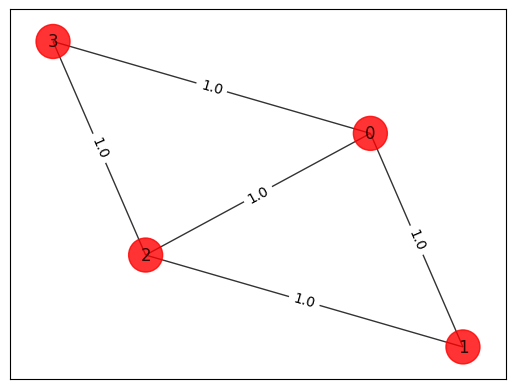

In [42]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

now, i'll try to compute the weight matrix from the random graph

1. Need to define a matrix w of size n by n, initialized with zeros.
1. The for loops iterate over all possible pairs of nodes in the graph (i and j go from 0 to n-1).
1. Need to use get_edge_data method of the g object to get the weight of the edge between nodes i and j. If the edge doesn't exist, the method returns 0.
1. If the edge between nodes i and j has a non-zero weight, need to sets the corresponding entry in the w matrix to the weight.
1. Finally, need to prints the w matrix.


In [44]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


This matrix represents a weighted graph with 4 vertices. The diagonal of the matrix is all 0s, which indicates that there are no self-loops in the graph. The values in the upper and lower triangles of the matrix are the weights of the edges between the corresponding vertices. For example, w[0,1] = 1 indicates that there is an edge with weight 1 connecting vertex 0 and vertex 1.
row 1, column3, for example => w[1,3] = 0, indicates that theres no connections between vertex 1 and 3.
The matrix is symmetric, which indicates that the graph is undirected. Overall, this code shows how to extract the weight matrix from a given graph.


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


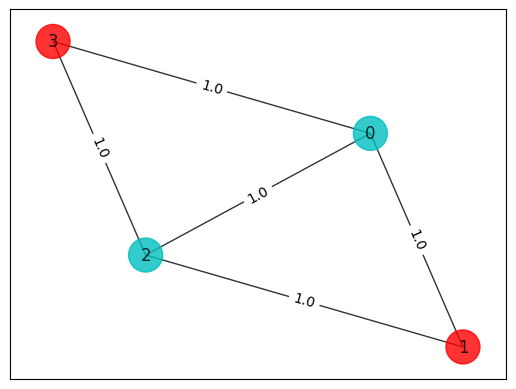

In [45]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

# Mapping the matrix to the Ising problem


In [47]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [48]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))


Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII
